
# **Exploring VGG Architectures for Enhanced Model Performance**

Having achieved an accuracy of approximately 88% with the ResNet18 model, we are motivated to explore additional architectures to enhance our model's performance further. In particular, we will experiment with the VGG16 and VGG19 architectures, both known for their deep convolutional layers and strong performance in image classification tasks. Our objective is to implement these architectures to introduce modifications and improvements, aiming to generalize the results effectively across various datasets. By leveraging the increased depth and complexity of VGG16 and VGG19, we anticipate discovering potential performance gains and a higher accuracy compared to our previous results with ResNet18. This exploration will help us identify the most suitable model architecture for our specific classification task, ensuring robust and reliable performance.

##**IMPORTING THE REQUIRED LIBRARIES**

In [ ]:
import os
import random
import shutil
import warnings
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torchvision.utils import make_grid
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/CUB_200_2011.tgz'

import tarfile
if file_path.endswith("tgz"):
    tar = tarfile.open(file_path, "r:gz")
    tar.extractall()
    tar.close()

extracted_folder_path = 'CUB_200_2011'
image_folder_path = os.path.join(extracted_folder_path, 'images')


for root, dirs, files in os.walk(image_folder_path):
    for file in files:
        print(os.path.join(root, file))
    break

images_txt_path = os.path.join(extracted_folder_path, 'images.txt')
labels_txt_path = os.path.join(extracted_folder_path, 'image_class_labels.txt')
class_names_path = os.path.join(extracted_folder_path, 'classes.txt')

images_df = pd.read_csv(images_txt_path, sep=' ', header=None, names=['image_id', 'file_path'])
labels_df = pd.read_csv(labels_txt_path, sep=' ', header=None, names=['image_id', 'class_id'])
class_names_df = pd.read_csv(class_names_path, sep=' ', header=None, names=['class_id', 'class_name'])

data_df = pd.merge(images_df, labels_df, on='image_id')
data_df = pd.merge(data_df, class_names_df, on='class_id')

data_df['file_path'] = data_df['file_path'].apply(lambda x: os.path.join(image_folder_path, x))
print(data_df.shape)

(11788, 4)


In [ ]:
data_df

,image_id,file_path,class_id,class_name
0,1,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
1,2,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
2,3,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
3,4,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
4,5,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
...,...,...,...,...
11783,11784,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat
11784,11785,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat
11785,11786,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat
11786,11787,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat


# **Filtering and Copying Images Based on Desired Categories**

In [ ]:
output_folder = 'filtered_images'
desired_categories = [7, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 28, 32, 35, 36, 42, 44,
                      45, 47, 48, 54, 55, 57, 59, 63, 67, 68, 72, 75, 76, 77, 78, 79, 85, 87,
                      89, 91, 93, 95, 99, 104,108, 109, 111, 114, 116, 118, 134, 136, 138,
                      139, 143, 149, 158, 163, 164,  186, 191, 192, 194]


train_data = data_df[data_df['class_id'].isin(desired_categories)]


for index, row in train_data.iterrows():
    class_name = row['class_name']
    src = row['file_path']
    dst = os.path.join(output_folder, class_name, os.path.basename(src))
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copy(src, dst)


for root, dirs, files in os.walk(output_folder):
    for file in files:
        print(os.path.join(root, file))
    break

# **Cleaning Class Names and Remapping Class IDs in the Training Dataset**

In [ ]:

import re
def clean_class_name(class_name):

    cleaned_name = re.sub(r'^\d+\.', '', class_name).strip()
    return cleaned_name

train_data['class_name'] = train_data['class_name'].apply(clean_class_name)
class_id_mapping = {original_id: new_id for new_id, original_id in enumerate(desired_categories)}

train_data['class_id'] = train_data['class_id'].map(class_id_mapping)
train_data = train_data.drop(columns=['image_id'])
train_data = train_data[['class_id', 'file_path', 'class_name']]
train_data.head()

,class_id,file_path,class_name
323,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
324,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
325,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
326,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
327,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet


Class distribution:
class_id
0     53
1     59
2     60
3     56
4     60
      ..
58    60
59    60
60    60
61    60
62    60
Name: count, Length: 63, dtype: int64


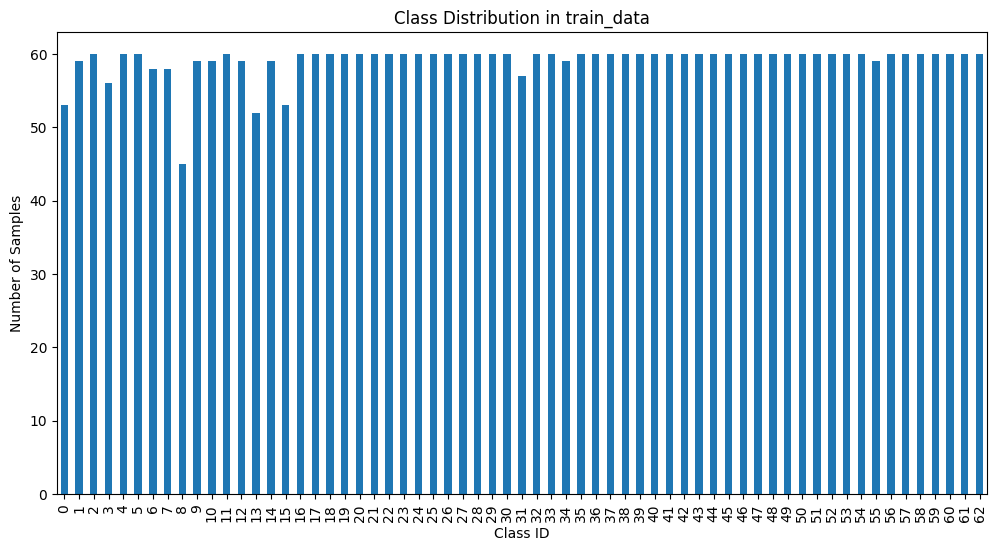

Minimum samples in a class: 45
Maximum samples in a class: 60
Mean number of samples per class: 59.13
Standard deviation of samples per class: 2.47
The classes are balanced.


In [ ]:
class_distribution = train_data['class_id'].value_counts().sort_index()
print("Class distribution:")
print(class_distribution)

plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in train_data')
plt.show()

min_samples = class_distribution.min()
max_samples = class_distribution.max()
mean_samples = class_distribution.mean()
std_samples = class_distribution.std()

print(f"Minimum samples in a class: {min_samples}")
print(f"Maximum samples in a class: {max_samples}")
print(f"Mean number of samples per class: {mean_samples:.2f}")
print(f"Standard deviation of samples per class: {std_samples:.2f}")

threshold = 0.1
is_balanced = std_samples / mean_samples < threshold

if is_balanced:
    print("The classes are balanced.")
else:
    print("The classes are not balanced.")

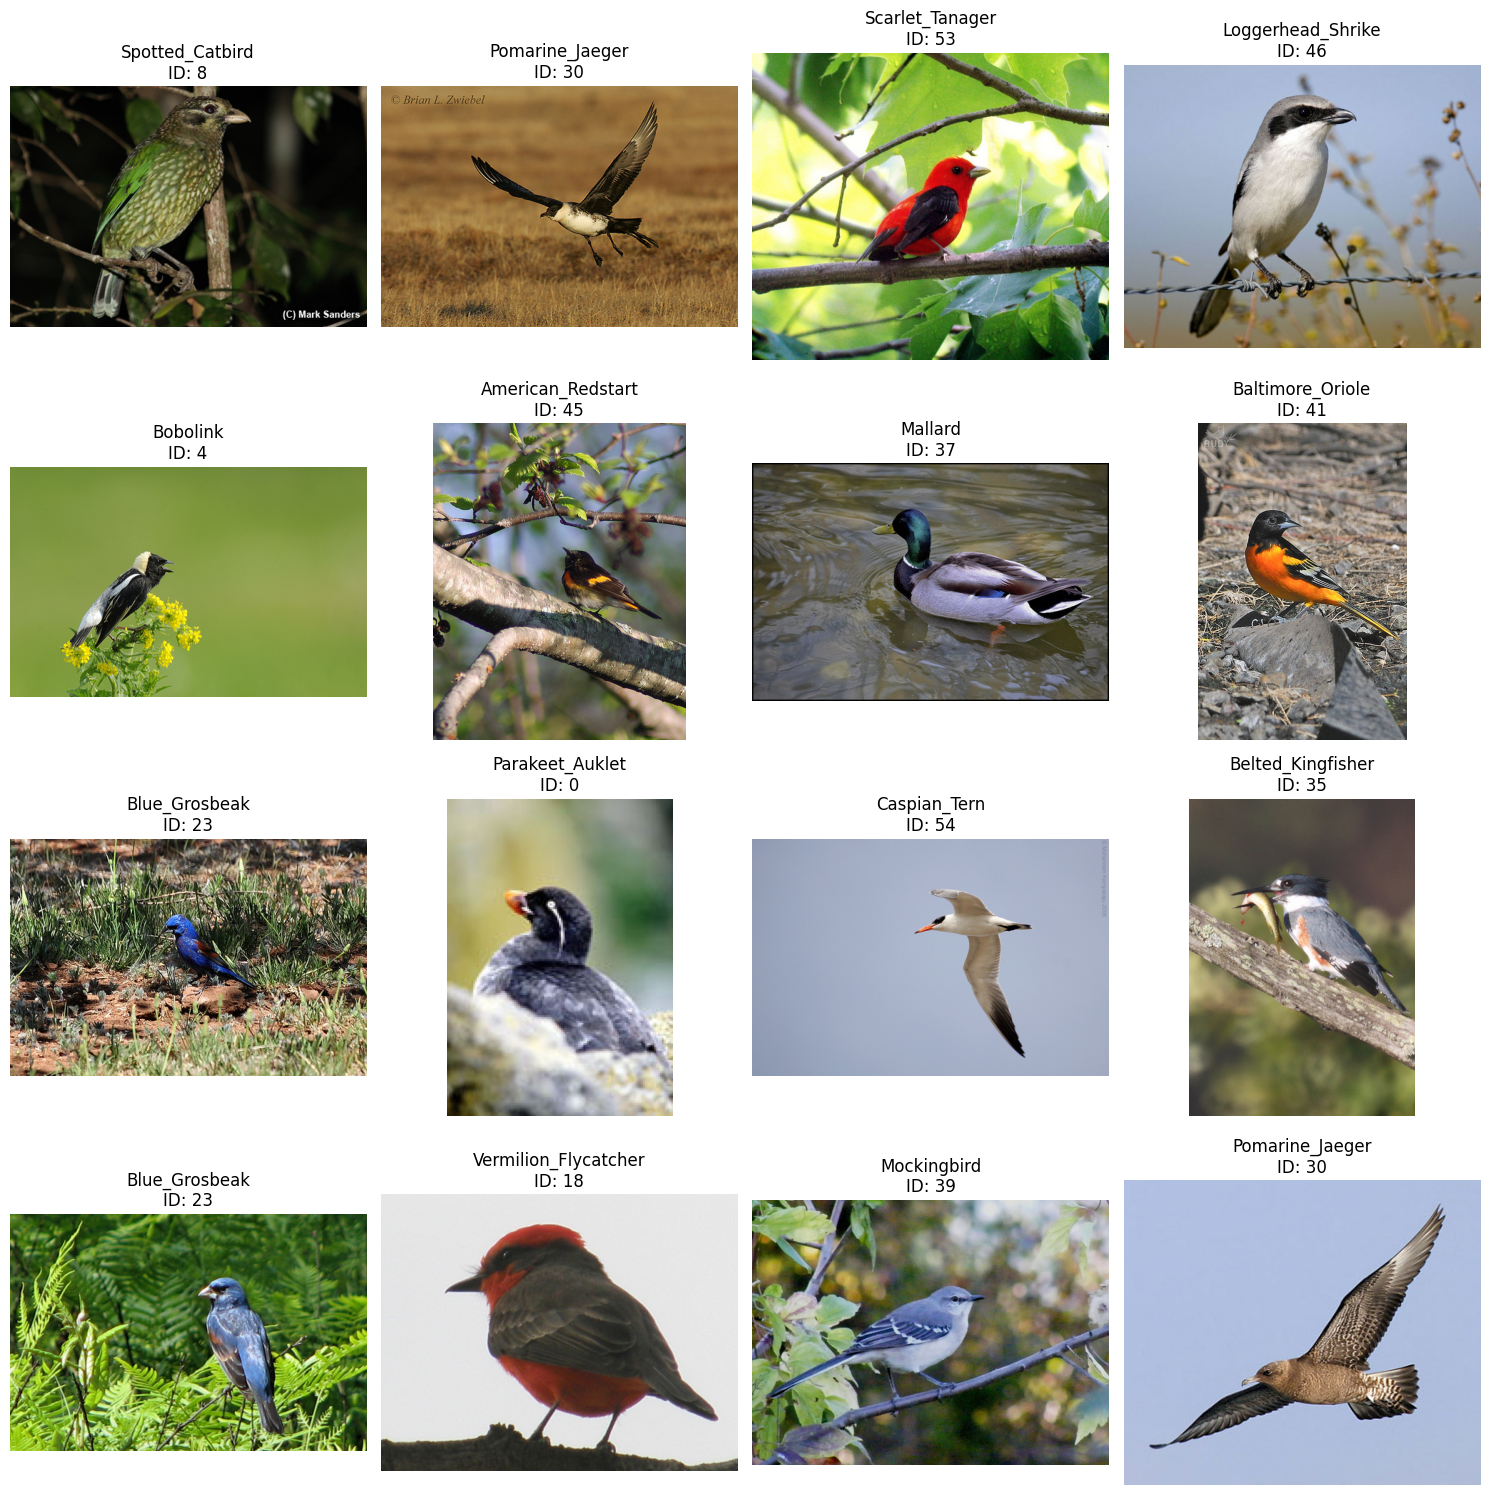

In [ ]:
def plot_images_with_labels(data_df, num_images=16):
    sample_data = data_df.sample(n=num_images)

    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.flatten()
    for ax, (idx, row) in zip(axes, sample_data.iterrows()):
        img = Image.open(row['file_path'])
        ax.imshow(img)
        ax.set_title(f"{row['class_name']}\nID: {row['class_id']}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
plot_images_with_labels(train_data)

# **Training and Validation Pipeline for VGG16 with Data Augmentation and Early Stopping**

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class MultiClassDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.iloc[idx]['class_id']
        if self.transform:
            image = self.transform(image)
        return image, label
dataset = MultiClassDataset(dataframe=train_data, transform=transform_train)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
model = models.vgg16(pretrained=True)

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(desired_categories))
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)  # Adjust lr and momentum as needed
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


def TabularFormat(epochs, train_cost, train_acc, eval_cost, eval_acc):
    ep = list(range(1, epochs + 1))
    return pd.DataFrame(list(zip(ep, train_cost, train_acc, eval_cost, eval_acc)),
                        columns=['Epoch Value', 'Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])
num_epochs = 50
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
best_val_loss = float('inf')
patience = 5
count = 0

# Training loop
for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0
    total_train = 0
    correct_train = 0
    model.train()

    # Training
    for itr, (image, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        image, label = image.to(device), label.to(device)  # Move data to GPU

        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, label)
        total_train_loss += loss.item()

        predicted = torch.argmax(pred, 1)
        total_train += label.size(0)
        correct_train += (predicted == label).sum().item()

        loss.backward()
        optimizer.step()

    accuracy_train = (100 * correct_train) / total_train
    train_accuracy.append(accuracy_train)
    total_train_loss /= len(train_loader)
    train_loss.append(total_train_loss)

    # Validation
    model.eval()
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for itr, (image, label) in enumerate(val_loader):
            image, label = image.to(device), label.to(device)  # Move data to GPU

            pred = model(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()

            predicted = torch.argmax(pred, dim=1)
            total_val += label.size(0)
            correct_val += (predicted == label).sum().item()

    accuracy_val = (100 * correct_val) / total_val
    val_accuracy.append(accuracy_val)
    total_val_loss /= len(val_loader)
    val_loss.append(total_val_loss)

    print(f'\nEpoch: {epoch + 1}/{num_epochs}, Train Loss: {total_train_loss:.8f}, '
          f'Train Accuracy: {accuracy_train:.8f}, Val Loss: {total_val_loss:.8f}, '
          f'Val Accuracy: {accuracy_val:.8f}')

    # Check for early stopping
    if total_val_loss < best_val_loss:
        count = 0
        best_val_loss = total_val_loss
        print(f"Saving the model state dictionary for Epoch: {epoch + 1} with Validation loss: {total_val_loss:.8f}")
        torch.save(model.state_dict(), "model.pth")
    else:
        count += 1

    if count == patience:
        print(f'Validation loss did not improve for {patience} consecutive epochs. Stopping training.')
        break

    scheduler.step()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 164MB/s]
100%|██████████| 94/94 [00:42<00:00,  2.21it/s]



Epoch: 1/50, Train Loss: 3.49424138, Train Accuracy: 15.23489933, Val Loss: 3.37059900, Val Accuracy: 17.98657718
Saving the model state dictionary for Epoch: 1 with Validation loss: 3.37059900


100%|██████████| 94/94 [00:40<00:00,  2.33it/s]



Epoch: 2/50, Train Loss: 3.01421491, Train Accuracy: 23.32214765, Val Loss: 2.01907131, Val Accuracy: 43.62416107
Saving the model state dictionary for Epoch: 2 with Validation loss: 2.01907131


100%|██████████| 94/94 [00:41<00:00,  2.27it/s]



Epoch: 3/50, Train Loss: 2.00183621, Train Accuracy: 44.22818792, Val Loss: 2.05840584, Val Accuracy: 43.89261745


100%|██████████| 94/94 [00:41<00:00,  2.29it/s]



Epoch: 4/50, Train Loss: 1.63243548, Train Accuracy: 53.95973154, Val Loss: 1.86713571, Val Accuracy: 47.91946309
Saving the model state dictionary for Epoch: 4 with Validation loss: 1.86713571


100%|██████████| 94/94 [00:41<00:00,  2.28it/s]



Epoch: 5/50, Train Loss: 1.23445965, Train Accuracy: 65.70469799, Val Loss: 1.25075860, Val Accuracy: 66.30872483
Saving the model state dictionary for Epoch: 5 with Validation loss: 1.25075860


100%|██████████| 94/94 [00:41<00:00,  2.28it/s]



Epoch: 6/50, Train Loss: 0.48291516, Train Accuracy: 85.46979866, Val Loss: 0.76743135, Val Accuracy: 79.19463087
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.76743135


100%|██████████| 94/94 [00:41<00:00,  2.28it/s]



Epoch: 7/50, Train Loss: 0.28114609, Train Accuracy: 90.87248322, Val Loss: 0.74617992, Val Accuracy: 79.59731544
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.74617992


100%|██████████| 94/94 [00:41<00:00,  2.28it/s]



Epoch: 8/50, Train Loss: 0.19207113, Train Accuracy: 94.16107383, Val Loss: 0.73328542, Val Accuracy: 81.34228188
Saving the model state dictionary for Epoch: 8 with Validation loss: 0.73328542


100%|██████████| 94/94 [00:41<00:00,  2.28it/s]



Epoch: 9/50, Train Loss: 0.15337998, Train Accuracy: 95.53691275, Val Loss: 0.72875710, Val Accuracy: 80.67114094
Saving the model state dictionary for Epoch: 9 with Validation loss: 0.72875710


100%|██████████| 94/94 [00:41<00:00,  2.28it/s]



Epoch: 10/50, Train Loss: 0.12207734, Train Accuracy: 96.04026846, Val Loss: 0.75523637, Val Accuracy: 81.20805369


100%|██████████| 94/94 [00:41<00:00,  2.28it/s]



Epoch: 11/50, Train Loss: 0.09940875, Train Accuracy: 96.94630872, Val Loss: 0.74585935, Val Accuracy: 81.20805369


100%|██████████| 94/94 [00:41<00:00,  2.28it/s]



Epoch: 12/50, Train Loss: 0.08592196, Train Accuracy: 97.51677852, Val Loss: 0.74735381, Val Accuracy: 81.47651007


100%|██████████| 94/94 [00:41<00:00,  2.28it/s]



Epoch: 13/50, Train Loss: 0.09422220, Train Accuracy: 96.91275168, Val Loss: 0.74510341, Val Accuracy: 81.61073826


100%|██████████| 94/94 [00:41<00:00,  2.29it/s]



Epoch: 14/50, Train Loss: 0.08008272, Train Accuracy: 97.81879195, Val Loss: 0.74947623, Val Accuracy: 81.34228188
Validation loss did not improve for 5 consecutive epochs. Stopping training.


In [ ]:
df_16 = TabularFormat(num_epochs, train_loss, train_accuracy, val_loss, val_accuracy)
df_16

,Epoch Value,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy
0,1,3.494241,15.234899,3.370599,17.986577
1,2,3.014215,23.322148,2.019071,43.624161
2,3,2.001836,44.228188,2.058406,43.892617
3,4,1.632435,53.959732,1.867136,47.919463
4,5,1.234460,65.704698,1.250759,66.308725
5,6,0.482915,85.469799,0.767431,79.194631
6,7,0.281146,90.872483,0.746180,79.597315
7,8,0.192071,94.161074,0.733285,81.342282
8,9,0.153380,95.536913,0.728757,80.671141
9,10,0.122077,96.040268,0.755236,81.208054


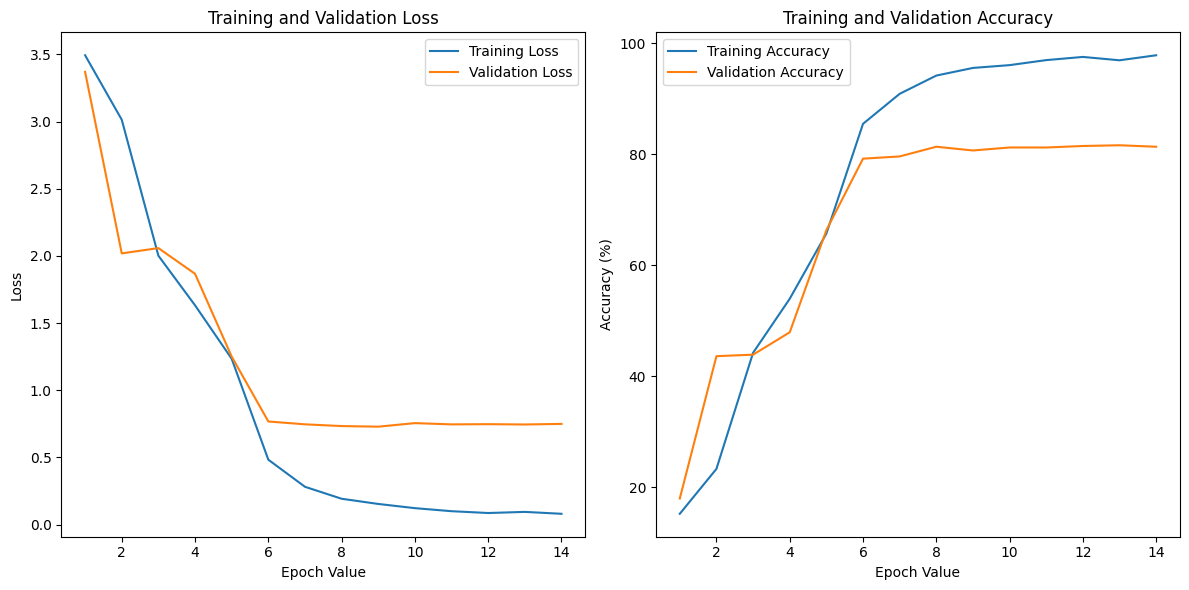

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_16['Epoch Value'], df_16['Training Loss'], label='Training Loss')
plt.plot(df_16['Epoch Value'], df_16['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch Value')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_16['Epoch Value'], df_16['Training Accuracy'], label='Training Accuracy')
plt.plot(df_16['Epoch Value'], df_16['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch Value')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **Conclusion:**
The VGG16 model exhibited excellent performance in both training and validation phases. The substantial decrease in training and validation losses, coupled with the high accuracy rates, confirms the model’s effectiveness in the bird species classification task. The early stopping criterion ensured that the model was not overfitted and achieved robust generalization on the validation dataset.

Future steps will involve evaluating this trained model on the Birds_525_species dataset to further validate its performance in a domain-specific context and compare it with other models, such as VGG19.

# **Advancing Classification Performance: From VGG16 to VGG19 for Enhanced Accuracy**
Having successfully trained the model using the VGG16 architecture and achieved an accuracy of approximately 81.34%, we now aim to further enhance performance by experimenting with the VGG19 model. The VGG16 model demonstrated impressive results, with significant reductions in both training and validation losses, and a high validation accuracy of 81.34%.

To potentially improve upon these results, we will proceed with training the model using the VGG19 architecture. This exploration will help us assess whether VGG19 can offer enhancements in accuracy and overall model performance. By comparing the outcomes from both VGG16 and VGG19, we seek to identify any improvements and determine the best-performing model for our bird species classification task.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class MultiClassDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.iloc[idx]['class_id']
        if self.transform:
            image = self.transform(image)
        return image, label

dataset = MultiClassDataset(dataframe=train_data, transform=transform_train)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = models.vgg19(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(desired_categories))  # Ensure len(desired_categories) matches your number of classes
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)  # Adjust lr and momentum as needed
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def TabularFormat(epochs, train_cost, train_acc, eval_cost, eval_acc):
    ep = list(range(1, epochs + 1))
    return pd.DataFrame(list(zip(ep, train_cost, train_acc, eval_cost, eval_acc)),
                        columns=['Epoch Value', 'Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])

num_epochs = 50
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
best_val_loss = float('inf')
patience = 5
count = 0

# Training loop
for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0
    total_train = 0
    correct_train = 0
    model.train()

    # Training
    for itr, (image, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        image, label = image.to(device), label.to(device)  # Move data to GPU

        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, label)
        total_train_loss += loss.item()

        predicted = torch.argmax(pred, 1)
        total_train += label.size(0)
        correct_train += (predicted == label).sum().item()

        loss.backward()
        optimizer.step()

    accuracy_train = (100 * correct_train) / total_train
    train_accuracy.append(accuracy_train)
    total_train_loss /= len(train_loader)
    train_loss.append(total_train_loss)

    # Validation
    model.eval()
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for itr, (image, label) in enumerate(val_loader):
            image, label = image.to(device), label.to(device)  # Move data to GPU

            pred = model(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()

            predicted = torch.argmax(pred, dim=1)
            total_val += label.size(0)
            correct_val += (predicted == label).sum().item()

    accuracy_val = (100 * correct_val) / total_val
    val_accuracy.append(accuracy_val)
    total_val_loss /= len(val_loader)
    val_loss.append(total_val_loss)

    print(f'\nEpoch: {epoch + 1}/{num_epochs}, Train Loss: {total_train_loss:.8f}, '
          f'Train Accuracy: {accuracy_train:.8f}, Val Loss: {total_val_loss:.8f}, '
          f'Val Accuracy: {accuracy_val:.8f}')

    # Check for early stopping
    if total_val_loss < best_val_loss:
        count = 0
        best_val_loss = total_val_loss
        print(f"Saving the model state dictionary for Epoch: {epoch + 1} with Validation loss: {total_val_loss:.8f}")
        torch.save(model.state_dict(), "model.pth")
    else:
        count += 1

    if count == patience:
        print(f'Validation loss did not improve for {patience} consecutive epochs. Stopping training.')
        break

    scheduler.step()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 77.1MB/s]
100%|██████████| 94/94 [00:49<00:00,  1.91it/s]



Epoch: 1/50, Train Loss: 3.63948431, Train Accuracy: 11.94630872, Val Loss: 3.20311709, Val Accuracy: 17.44966443
Saving the model state dictionary for Epoch: 1 with Validation loss: 3.20311709


100%|██████████| 94/94 [00:48<00:00,  1.94it/s]



Epoch: 2/50, Train Loss: 2.78180428, Train Accuracy: 27.38255034, Val Loss: 2.22196998, Val Accuracy: 41.07382550
Saving the model state dictionary for Epoch: 2 with Validation loss: 2.22196998


100%|██████████| 94/94 [00:48<00:00,  1.94it/s]



Epoch: 3/50, Train Loss: 1.93860291, Train Accuracy: 46.47651007, Val Loss: 1.73663148, Val Accuracy: 51.67785235
Saving the model state dictionary for Epoch: 3 with Validation loss: 1.73663148


100%|██████████| 94/94 [00:48<00:00,  1.94it/s]



Epoch: 4/50, Train Loss: 1.69609917, Train Accuracy: 52.78523490, Val Loss: 1.43908945, Val Accuracy: 60.93959732
Saving the model state dictionary for Epoch: 4 with Validation loss: 1.43908945


100%|██████████| 94/94 [00:48<00:00,  1.95it/s]



Epoch: 5/50, Train Loss: 1.16780312, Train Accuracy: 67.31543624, Val Loss: 1.61723610, Val Accuracy: 56.10738255


100%|██████████| 94/94 [00:48<00:00,  1.95it/s]



Epoch: 6/50, Train Loss: 0.57874941, Train Accuracy: 83.02013423, Val Loss: 0.76330883, Val Accuracy: 79.19463087
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.76330883


100%|██████████| 94/94 [00:48<00:00,  1.94it/s]



Epoch: 7/50, Train Loss: 0.25570879, Train Accuracy: 91.91275168, Val Loss: 0.69178180, Val Accuracy: 81.87919463
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.69178180


100%|██████████| 94/94 [00:48<00:00,  1.94it/s]



Epoch: 8/50, Train Loss: 0.18320695, Train Accuracy: 93.92617450, Val Loss: 0.69338016, Val Accuracy: 83.62416107


100%|██████████| 94/94 [00:48<00:00,  1.95it/s]



Epoch: 9/50, Train Loss: 0.14324204, Train Accuracy: 95.33557047, Val Loss: 0.70936733, Val Accuracy: 83.75838926


100%|██████████| 94/94 [00:48<00:00,  1.94it/s]



Epoch: 10/50, Train Loss: 0.11208171, Train Accuracy: 96.34228188, Val Loss: 0.71347151, Val Accuracy: 82.68456376


100%|██████████| 94/94 [00:48<00:00,  1.95it/s]



Epoch: 11/50, Train Loss: 0.07802512, Train Accuracy: 97.71812081, Val Loss: 0.69890547, Val Accuracy: 83.35570470


100%|██████████| 94/94 [00:48<00:00,  1.94it/s]



Epoch: 12/50, Train Loss: 0.07662310, Train Accuracy: 97.78523490, Val Loss: 0.69121784, Val Accuracy: 83.22147651
Saving the model state dictionary for Epoch: 12 with Validation loss: 0.69121784


100%|██████████| 94/94 [00:48<00:00,  1.94it/s]



Epoch: 13/50, Train Loss: 0.08458252, Train Accuracy: 97.38255034, Val Loss: 0.69467147, Val Accuracy: 83.08724832


100%|██████████| 94/94 [00:48<00:00,  1.95it/s]



Epoch: 14/50, Train Loss: 0.07357269, Train Accuracy: 97.75167785, Val Loss: 0.69438555, Val Accuracy: 82.95302013


100%|██████████| 94/94 [00:48<00:00,  1.95it/s]



Epoch: 15/50, Train Loss: 0.08652772, Train Accuracy: 97.55033557, Val Loss: 0.69677178, Val Accuracy: 83.35570470


100%|██████████| 94/94 [00:48<00:00,  1.94it/s]



Epoch: 16/50, Train Loss: 0.07137840, Train Accuracy: 98.08724832, Val Loss: 0.69646788, Val Accuracy: 83.35570470


100%|██████████| 94/94 [00:48<00:00,  1.94it/s]



Epoch: 17/50, Train Loss: 0.07008588, Train Accuracy: 97.75167785, Val Loss: 0.69707096, Val Accuracy: 83.22147651
Validation loss did not improve for 5 consecutive epochs. Stopping training.


In [ ]:
# Create and display the tabular summary of the training process
df_19 = TabularFormat(num_epochs, train_loss, train_accuracy, val_loss, val_accuracy)
df_19

,Epoch Value,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy
0,1,3.639484,11.946309,3.203117,17.449664
1,2,2.781804,27.382550,2.221970,41.073826
2,3,1.938603,46.476510,1.736631,51.677852
3,4,1.696099,52.785235,1.439089,60.939597
4,5,1.167803,67.315436,1.617236,56.107383
5,6,0.578749,83.020134,0.763309,79.194631
6,7,0.255709,91.912752,0.691782,81.879195
7,8,0.183207,93.926174,0.693380,83.624161
8,9,0.143242,95.335570,0.709367,83.758389
9,10,0.112082,96.342282,0.713472,82.684564


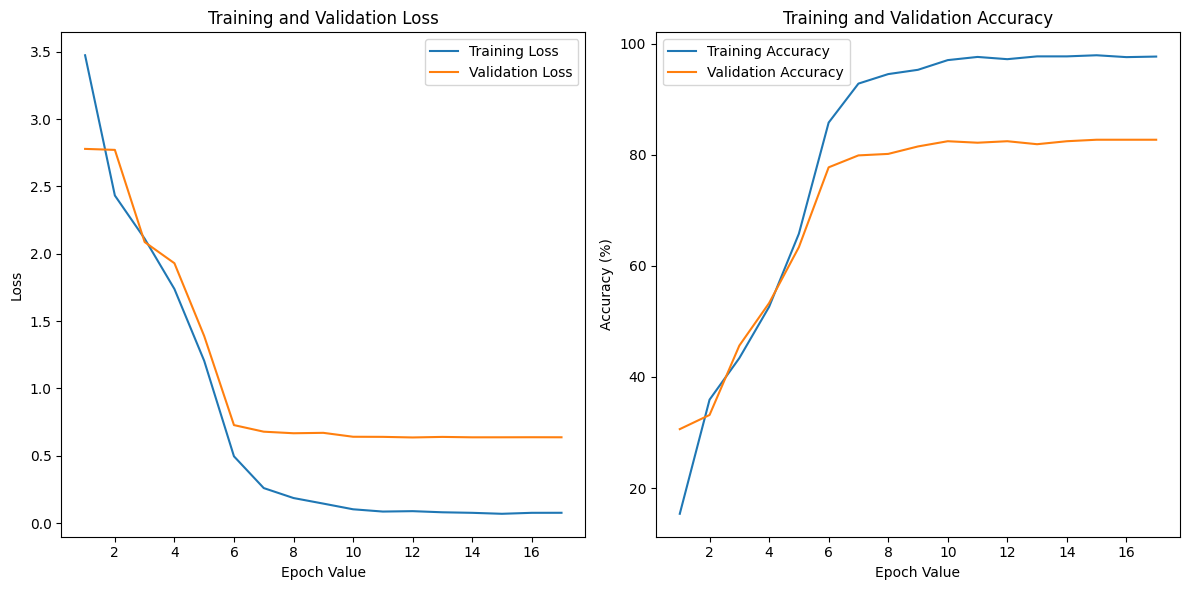

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_19['Epoch Value'], df_19['Training Loss'], label='Training Loss')
plt.plot(df_19['Epoch Value'], df_19['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch Value')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_19['Epoch Value'], df_19['Training Accuracy'], label='Training Accuracy')
plt.plot(df_19['Epoch Value'], df_19['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch Value')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()